<a href="https://colab.research.google.com/github/sumanyurosha/deep-learning-v2-pytorch/blob/master/autoencoder/convolutional-autoencoder/Upsampling_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Autoencoder

Sticking with the MNIST dataset, let's improve our autoencoder's performance using convolutional layers. We'll build a convolutional autoencoder to compress the MNIST dataset. 

>The encoder portion will be made of convolutional and pooling layers and the decoder will be made of **upsampling and convolutional layers**.

<img src='https://github.com/sumanyurosha/deep-learning-v2-pytorch/blob/master/autoencoder/convolutional-autoencoder/notebook_ims/autoencoder_1.png?raw=1' />

### Compressed Representation

A compressed representation can be great for saving and sharing any kind of data in a way that is more efficient than storing raw data. In practice, the compressed representation often holds key information about an input image and we can use it for denoising images or oher kinds of reconstruction and transformation!

<img src='https://github.com/sumanyurosha/deep-learning-v2-pytorch/blob/master/autoencoder/convolutional-autoencoder/notebook_ims/denoising.png?raw=1' width=60%/>

Let's get started by importing our libraries and getting the dataset.

In [0]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

In [0]:
# Create training and test dataloaders

num_workers = 0
# how many samples per batch to load
batch_size = 20

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

### Visualize the Data

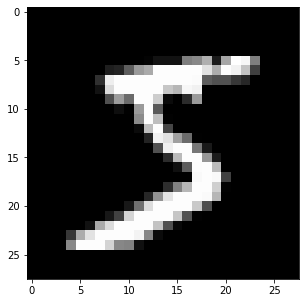

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

---
## Convolutional  Autoencoder

The encoder part of the network will be a typical convolutional pyramid. Each convolutional layer will be followed by a max-pooling layer to reduce the dimensions of the layers. The decoder though might be something new to you. The decoder needs to convert from a narrow representation to a wide reconstructed image. For example, the representation could be a 4x4x8 max-pool layer. This is the output of the encoder, but also the input to the decoder. We want to get a 28x28x1 image out from the decoder so we need to work our way back up from the narrow decoder input layer. A schematic of the network is shown below.

<img src='https://github.com/sumanyurosha/deep-learning-v2-pytorch/blob/master/autoencoder/convolutional-autoencoder/notebook_ims/conv_enc_2.png?raw=1' width=600px>


### Upsampling + Convolutions, Decoder

This decoder uses a combination of nearest-neighbor **upsampling and normal convolutional layers** to increase the width and height of the input layers.

It is important to note that transpose convolution layers can lead to artifacts in the final images, such as checkerboard patterns. This is due to overlap in the kernels which can be avoided by setting the stride and kernel size equal. In [this Distill article](http://distill.pub/2016/deconv-checkerboard/) from Augustus Odena, *et al*, the authors show that these checkerboard artifacts can be avoided by resizing the layers using nearest neighbor or bilinear interpolation (upsampling) followed by a convolutional layer. This is the approach we take, here.

#### TODO: Build the network shown above. 
> Build the encoder out of a series of convolutional and pooling layers. 
> When building the decoder, use a combination of upsampling and normal, convolutional layers.

In [4]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        # encoder layers

        # conv layer, depth 1 -> 16
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        # conv layer, depth 16 -> 4
        self.conv2 = nn.Conv2d(16, 4, kernel_size=3, padding=1)
        # kernel_size = 2, stride = 2
        self.maxpool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        # decoder layers
        
        # conv layer, depth 4 -> 16
        self.conv3 = nn.Conv2d(4, 16, kernel_size=3, padding=1)
        # conv layer, depth 16 -> 1
        self.conv4 = nn.Conv2d(16, 1, kernel_size=3, padding=1)
        

    def forward(self, x):
        
        # encoder layer
        x = self.relu(self.conv1(x))
        x = self.maxpool(x)
        x = self.relu(self.conv2(x))
        x = self.maxpool(x)

        # decoder layer
        x = F.upsample(x, scale_factor=2, mode='nearest')
        x = self.relu(self.conv3(x))
        x = F.upsample(x, scale_factor=2, mode='nearest')
        x = self.sigmoid(self.conv4(x))
        
        return x

# initialize the NN
model = ConvAutoencoder()
print(model)

ConvAutoencoder(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (conv3): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


---
## Training

Here I'll write a bit of code to train the network. I'm not too interested in validation here, so I'll just monitor the training loss and the test loss afterwards. 

We are not concerned with labels in this case, just images, which we can get from the `train_loader`. Because we're comparing pixel values in input and output images, it will be best to use a loss that is meant for a regression task. Regression is all about comparing quantities rather than probabilistic values. So, in this case, I'll use `MSELoss`. And compare output images and input images as follows:
```
loss = criterion(outputs, images)
```

Otherwise, this is pretty straightfoward training with PyTorch. We flatten our images, pass them into the autoencoder, and record the training loss as we go.

In [0]:
# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [6]:
# number of epochs to train the model
n_epochs = 30

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in train_loader:
        # _ stands in for labels, here
        # no need to flatten images
        images, _ = data
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        # calculate the loss
        loss = criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2404: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Epoch: 1 	Training Loss: 0.295114
Epoch: 2 	Training Loss: 0.144354
Epoch: 3 	Training Loss: 0.129163
Epoch: 4 	Training Loss: 0.122774
Epoch: 5 	Training Loss: 0.119301
Epoch: 6 	Training Loss: 0.117240
Epoch: 7 	Training Loss: 0.115800
Epoch: 8 	Training Loss: 0.114569
Epoch: 9 	Training Loss: 0.113309
Epoch: 10 	Training Loss: 0.112105
Epoch: 11 	Training Loss: 0.111101
Epoch: 12 	Training Loss: 0.110260
Epoch: 13 	Training Loss: 0.109530
Epoch: 14 	Training Loss: 0.108857
Epoch: 15 	Training Loss: 0.108249
Epoch: 16 	Training Loss: 0.107710
Epoch: 17 	Training Loss: 0.107214
Epoch: 18 	Training Loss: 0.106771
Epoch: 19 	Training Loss: 0.106343
Epoch: 20 	Training Loss: 0.105936
Epoch: 21 	Training Loss: 0.105529
Epoch: 22 	Training Loss: 0.105123
Epoch: 23 	Training Loss: 0.104680
Epoch: 24 	Training Loss: 0.104306
Epoch: 25 	Training Loss: 0.103971
Epoch: 26 	Training Loss: 0.103665
Epoch: 27 	Training Loss: 0.103340
Epoch: 28 	Training Loss: 0.103031
Epoch: 29 	Training Loss: 0.1

## Checking out the results

Below I've plotted some of the test images along with their reconstructions. For the most part these look pretty good except for some blurriness in some parts.

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2404: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


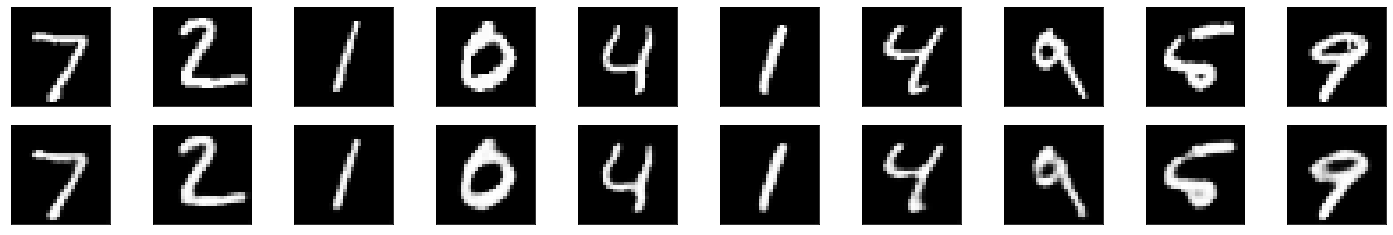

In [8]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# prep images for display
images = images.numpy()

# output is resized into a batch of iages
output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)